In [1]:
import pandas as pd 
import numpy as np
import random
import os 
import re
import time
import math
import argparse
import pymysql
import json
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig, BertTokenizer, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

In [2]:
os.getcwd()

'C:\\Users\\lamda\\Desktop\\AuD\\model1-2\\src'

In [3]:
data_path = "C:/Users/lamda/Desktop/AuD/model1-2/data"
base_model_path = "C:/Users/lamda/Desktop/AuD/base-model"
save_model_path = "C:/Users/lamda/Desktop/AuD/model1-2/model/"
config_path = "C:/Users/lamda/Desktop/AuD/model1-2/config"
log_path = "C:/Users/lamda/Desktop/AuD/model1-2/log"
config_file = "bert-base.json"

In [4]:
dsm_samp = pd.read_csv(os.path.join(data_path, 'dsm_samp2_test.csv'))
dsm_samp.head(3)

,id,text,label
0,4fws4y,"anyways, the doctor says be careful because yo...",3
1,t3_23p0b1,"i also have [aka *amerge*] for migraines, but ...",3
2,26twx8,all in all i feel worthless pretty much the on...,8


In [5]:
torch.cuda.is_available()

True

In [6]:
len(dsm_samp)

19869

In [7]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

training_config.pad = 'max_length'
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

### 1. Sentence Embedding

#### 1.1 non-trained model

In [7]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(base_model_path, 'bert-base'), model_max_length=128)
config = BertConfig.from_pretrained(os.path.join(base_model_path, 'bert-base', 'bert_config.json'), output_hidden_states=True)
model = BertModel.from_pretrained(os.path.join(base_model_path, 'bert-base'), config=config)

Some weights of the model checkpoint at /home/cori/AuD/base-model/bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
config.max_position_embeddings = 128

In [11]:
model.to(training_config.device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
dsm_emb = []

for idx in range(len(dsm_samp)):
    encoded = tokenizer.encode_plus(
        text=dsm_samp.text[idx],  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 64,  # maximum length of a sentence
        pad_to_max_length=True,  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
    # print(encoded)
    input_ids = torch.tensor(encoded['input_ids']).to(training_config.device)
    attn_mask = torch.tensor(encoded['attention_mask']).to(training_config.device)
    token_type_ids = torch.tensor(encoded['token_type_ids']).to(training_config.device)
    
    outputs = model(input_ids, attn_mask, token_type_ids)
    hidden_states = outputs[2]
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    dsm_emb.append(list(sentence_embedding.detach().cpu().numpy()))

In [ ]:
dsm_X = pd.DataFrame(dsm_emb, columns=range(len(dsm_emb[0])))
dsm_X

In [ ]:
dsm_y = dsm_samp.label.tolist()

In [ ]:
pca = PCA(n_components=30)
dsm_X = pca.fit_transform(dsm_X)

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(dsm_X)

In [ ]:
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=dsm_y, legend='full', palette=palette)
plt.show()

#### 1.2 Trained Model

In [40]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(base_model_path, 'bert-base'), model_max_length=128)
config = BertConfig.from_pretrained(os.path.join(base_model_path, 'bert-base', 'bert_config.json'), num_labels=9, output_hidden_states=True)
model = BertForSequenceClassification.from_pretrained(os.path.join(base_model_path, 'bert-base'), config=config)

Some weights of the model checkpoint at C:/Users/lamda/Desktop/AuD/base-model\bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceCl

In [41]:
config.max_position_embeddings = 128

In [42]:
1, 2, 15, 5, 8

(1, 2, 15, 5, 8)

In [43]:
model_name = os.path.join(save_model_path, 'label_9', 'bert-base', 'bert_dsm_1.pt')

In [44]:
model.load_state_dict(torch.load(model_name))
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [47]:
dsm_emb = []

for idx in range(len(dsm_samp)):
    encoded = tokenizer.encode_plus(
        text=dsm_samp.text[idx],  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length=True,  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
    input_ids = torch.tensor(encoded['input_ids']).to(training_config.device)
    attn_mask = torch.tensor(encoded['attention_mask']).to(training_config.device)
    token_type_ids = torch.tensor(encoded['token_type_ids']).to(training_config.device)
    
    outputs = model(input_ids, attn_mask, token_type_ids)
    # last_hidden_state = outputs.last_hidden_state
    # print(len(last_hidden_state), len(last_hidden_state[0]), last_hidden_state[0])
    hidden_states = outputs[1]
    # print(len(hidden_states), len(hidden_states[0]), len(hidden_states[0][0]))
    # print(hidden_states[-1][0][0])
    # token_vecs = hidden_states[-2][0]
    # sentence_embedding = torch.mean(token_vecs, dim=0)
    # dsm_emb.append(list(sentence_embedding.detach().cpu().numpy()))
    dsm_emb.append(hidden_states[-1][0][0].detach().cpu().numpy())

C:\Users\lamda\AppData\Local\Temp\ipykernel_2588\3134823717.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded['input_ids']).to(training_config.device)
C:\Users\lamda\AppData\Local\Temp\ipykernel_2588\3134823717.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attn_mask = torch.tensor(encoded['attention_mask']).to(training_config.device)
C:\Users\lamda\AppData\Local\Temp\ipykernel_2588\3134823717.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(encoded['token_type_id

In [48]:
dsm_X = pd.DataFrame(dsm_emb, columns=range(len(dsm_emb[0])))
dsm_X

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.630692,0.374461,0.036954,-0.078837,0.741715,-0.104958,-0.169119,-0.009849,-0.569558,-0.238027,...,0.659144,0.158726,0.000720,0.276547,0.217574,0.146240,0.870112,0.022455,-0.564834,0.308947
1,0.624702,0.373154,0.053122,-0.073547,0.701868,-0.110455,-0.145711,-0.047388,-0.562737,-0.223073,...,0.655777,0.155613,0.013258,0.291074,0.219153,0.129142,0.887756,0.039662,-0.562892,0.324005
2,-0.433838,0.642881,-0.772044,0.818601,-1.050206,-0.883692,0.624032,0.139478,0.461286,-0.330434,...,0.009792,0.249677,0.688051,-1.212680,0.263269,-1.258975,-0.028402,0.073881,-0.051191,0.882508
3,-0.432824,0.642288,-0.773122,0.819184,-1.050782,-0.882979,0.624624,0.138453,0.461127,-0.328918,...,0.008383,0.249698,0.688853,-1.211450,0.262094,-1.258600,-0.027552,0.073893,-0.050891,0.882479
4,-0.810040,-0.149763,0.750959,-1.020483,1.627348,-1.429071,-1.076903,0.297269,0.458783,-0.160661,...,0.365452,0.031730,0.222273,-0.949457,0.368328,-1.262163,-0.410535,-0.468907,0.732977,-1.078834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19864,0.190353,0.482218,0.729382,-0.024904,-0.212099,-0.132276,0.049101,-0.657334,-0.128059,-1.328120,...,0.562983,0.639676,-0.493416,0.324760,0.518886,-0.293413,-0.278819,0.711159,-0.555007,0.031645
19865,-0.433630,0.643026,-0.772605,0.819029,-1.050272,-0.883120,0.624093,0.138835,0.461126,-0.329969,...,0.008835,0.249979,0.688201,-1.212798,0.262977,-1.258273,-0.028372,0.074391,-0.051263,0.882110
19866,-0.818418,-0.146471,0.764823,-1.030801,1.632289,-1.423432,-1.072028,0.297917,0.448309,-0.169442,...,0.371904,0.036619,0.216483,-0.931652,0.362322,-1.261751,-0.404658,-0.472262,0.728323,-1.083230
19867,-0.433381,0.642896,-0.772788,0.818999,-1.050168,-0.882929,0.624424,0.139054,0.461144,-0.329876,...,0.008807,0.250068,0.688049,-1.212548,0.262790,-1.257999,-0.028324,0.074552,-0.050951,0.882172


In [ ]:
dsm_X.to_csv(os.path.join(data_path, 'emb', 'tiny-9-emb.csv'), index=False)

In [49]:
pca = PCA(n_components=30)
dsm_X = pca.fit_transform(dsm_X)

In [50]:
dsm_y = dsm_samp.label.tolist()

In [51]:
X_embedded = TSNE(n_components=2).fit_transform(dsm_X)

In [166]:
with open(os.path.join(data_path, 'emb', 'tiny-9-embedded.pickle'), 'wb') as f:
    pickle.dump(X_embedded, f, pickle.HIGHEST_PROTOCOL)

In [167]:
with open(os.path.join(data_path, 'emb', 'tiny-9-embedded.pickle'), 'rb') as f:
    X_embedded = pickle.load(f)

C:\Users\lamda\AppData\Local\Temp\ipykernel_2588\1128696437.py:2: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=dsm_y, legend='full', palette=palette)


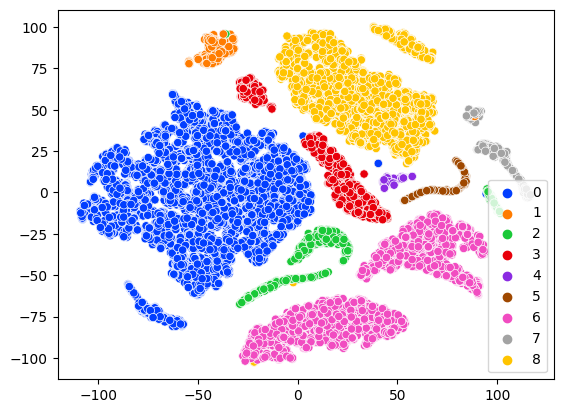

In [52]:
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=dsm_y, legend='full', palette=palette)
plt.show()

### 2. Word Embedding

In [53]:
text = 'I am depressed'
text2 = 'she is angry to me'

In [54]:
encoded = tokenizer.encode_plus(
    text=text2,  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 64,  # maximum length of a sentence
    pad_to_max_length=True,  # Add [PAD]s
    return_attention_mask = True,  # Generate the attention mask
    return_tensors = 'pt',  # ask the function to return PyTorch tensors
)
input_ids = torch.tensor(encoded['input_ids']).to(training_config.device)
attn_mask = torch.tensor(encoded['attention_mask']).to(training_config.device)
token_type_ids = torch.tensor(encoded['token_type_ids']).to(training_config.device)

/home/lamdaco/anaconda3/envs/lamda_base/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_570199/442271721.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded['input_ids']).to(training_config.device)
/tmp/ipykernel_570199/442271721.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().det